In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from leela_interp.core.effect_study import *
from leela_interp.core.alternative_moves import *

In [3]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")
model = Lc0sight("lc0.onnx", device=device)

Using device: cpu


In [46]:
study = EffectStudy(model, puzzlename="", n_examples=50)

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.all_effects = -torch.load(
/home/dcruz/Pivotal

The full dataset actually has 4M puzzles, but the scripts only consider the first 1M, and the default filters reduce that to 22k.

Max accuracy (main, L11): 0.77 +- 0.10
Max accuracy (main, L12): 0.74 +- 0.10
Max accuracy (random_model, L7): 0.26 +- 0.11
Max accuracy (random_model, L7): 0.13 +- 0.09


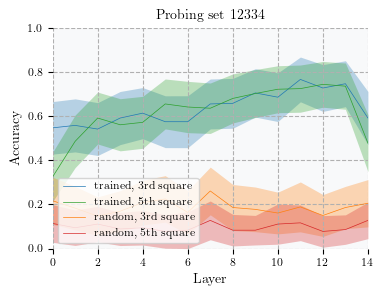

In [19]:
case_number = 1123456
case_number = 1123344
case_number = 11223
case_number = 11234
case_number = 12344
case_number = 11233
case_number = 12345
case_number = 12334
n_seeds = 5

SETTING_TO_PRETTY_NAME = {
    ("main", 3): "trained, 3rd square",
    ("main", 5): "trained, 5th square",
    ("random_model", 3): "random, 3rd square",
    ("random_model", 5): "random, 5th square",
}

if len(str(case_number)) == 7:
    SETTING_TO_PRETTY_NAME[("main", 7)] = "trained, 7th square"
    SETTING_TO_PRETTY_NAME[("random_model", 7)] = "random, 7th square"

def plot_probe_results(split="all"):
    fh.set(fast=False)
    plt.figure(figsize=(fh.HALF_WIDTH*1.5, 2*1.5))

    for i, setting in enumerate(["main", "random_model"]):
        for j, goal_square in enumerate(range(3, len(str(case_number)) + 1, 2)):
            results = np.zeros((15, n_seeds))
            for seed in range(n_seeds):
                with open(f"results/probing_{case_number}/{split}/{seed}/{goal_square}/{setting}.pkl", "rb") as f:
                    new_results = pickle.load(f)
                    results[:, seed] = new_results["accuracies"]

            means = results.mean(-1)
            squared_seed_errors = results.var(-1) / results.shape[-1]
            # Size of the eval dataset is 30% of all puzzles
            squared_acc_errors = means * (1 - means) / (0.3 * len(study.good_results[str(case_number)]))
            # 2 sigma errors
            errors = 2 * np.sqrt(squared_seed_errors + squared_acc_errors)

            max_layer = means.argmax()

            print(
                f"Max accuracy ({setting}, L{max_layer}): {means[max_layer]:.2f} +- {errors[max_layer]:.2f}"
            )Pivotal/leela-interp/effect_study.ipynb
            plt.plot(
                means,
                label=SETTING_TO_PRETTY_NAME[(setting, goal_square)],
                color=fh.COLORS[2*j + i],
                linewidth=fh.LINE_WIDTH,
            )
            plt.fill_between(
                range(15),
                means - errors,
                means + errors,
                color=fh.COLORS[2*j + i],
                alpha=fh.ERROR_ALPHA,
                linewidth=0,
            )

    plt.title(f"Probing set {case_number}")
    plt.xlabel("Layer")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")

    plt.ylim(0, 1.0)
    plt.xlim(0, 14)
    plt.gca().spines[:].set_visible(False)
    plt.gca().set_facecolor(fh.PLOT_FACE_COLOR)
    plt.grid(linestyle="--")
    plt.grid(which="minor", alpha=0.3, linestyle="--")

plot_probe_results()
fh.save(f"probing_{case_number}.pdf")

In [97]:
len(study.good_results['12344']), len(study.good_results['11234']), len(study.good_results['11223']), len(study.good_results['1123456']), len(study.good_results['1123344'])

(160, 3126, 185, 130, 57)

In [11]:
len(study.good_results['11233']), len(study.good_results['12345'])

(676, 430)

In [14]:
[(key, len(value)) for key, value in study.good_results.items()]

[('112', 7394),
 ('111', 3853),
 ('11234', 3126),
 ('123', 2455),
 ('11231', 1360),
 ('11233', 676),
 ('12345', 430),
 ('11222', 305),
 ('12334', 237),
 ('11112', 227),
 ('11123', 222),
 ('12333', 218),
 ('11122', 204),
 ('122', 202),
 ('11223', 185),
 ('12344', 160),
 ('1123456', 130),
 ('11221', 98),
 ('12342', 65),
 ('11111', 61),
 ('1123344', 57),
 ('12223', 56)]

# Global activation patching

## Residual stream

## Mate in 3 examples

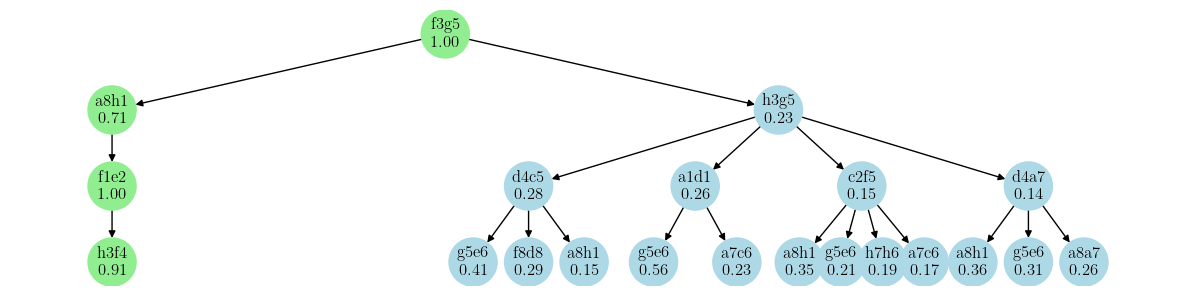

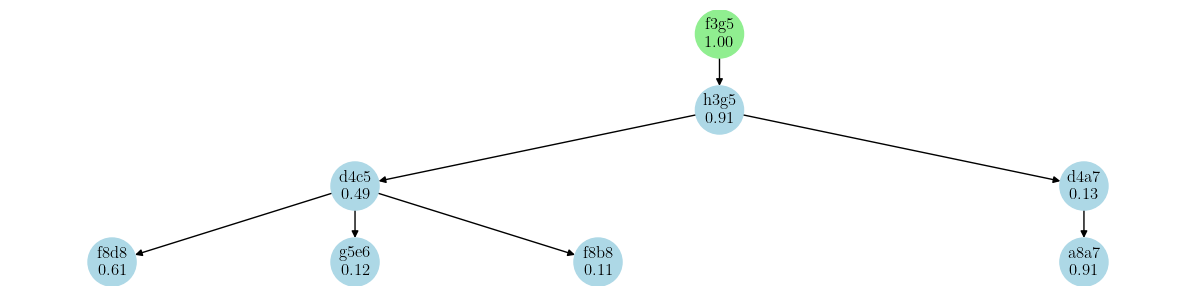

In [49]:
mask = study.good_mask[list(study.good_results).index('123')].copy()
puzzle_case = 5
puzzle_pos = np.where(mask)[0][puzzle_case]
mask[:] = False
mask[puzzle_pos] = True
puzzle = study.puzzles[mask].iloc[0]
board = LeelaBoard.from_puzzle(puzzle)
corrupted_board = LeelaBoard.from_fen(puzzle.corrupted_fen)
correct_moves = puzzle.Moves.split()
total_moveset = {correct_moves[0]: {'prob': 1.0} | get_top_moves(model, board, limit=3, min_prob=0.05)}
total_moveset_corrupted = {correct_moves[0]: {'prob': 1.0} | get_top_moves(model, corrupted_board, limit=3, min_prob=0.05)}
plot_game_trees([(correct_moves, total_moveset)], width=12, height=3)
plot_game_trees([(correct_moves, total_moveset_corrupted)], width=12, height=3)

0 ['a8h1', 'f1e2', 'h3f4'] [0.7125961780548096, 1.0, 0.9090977907180786]


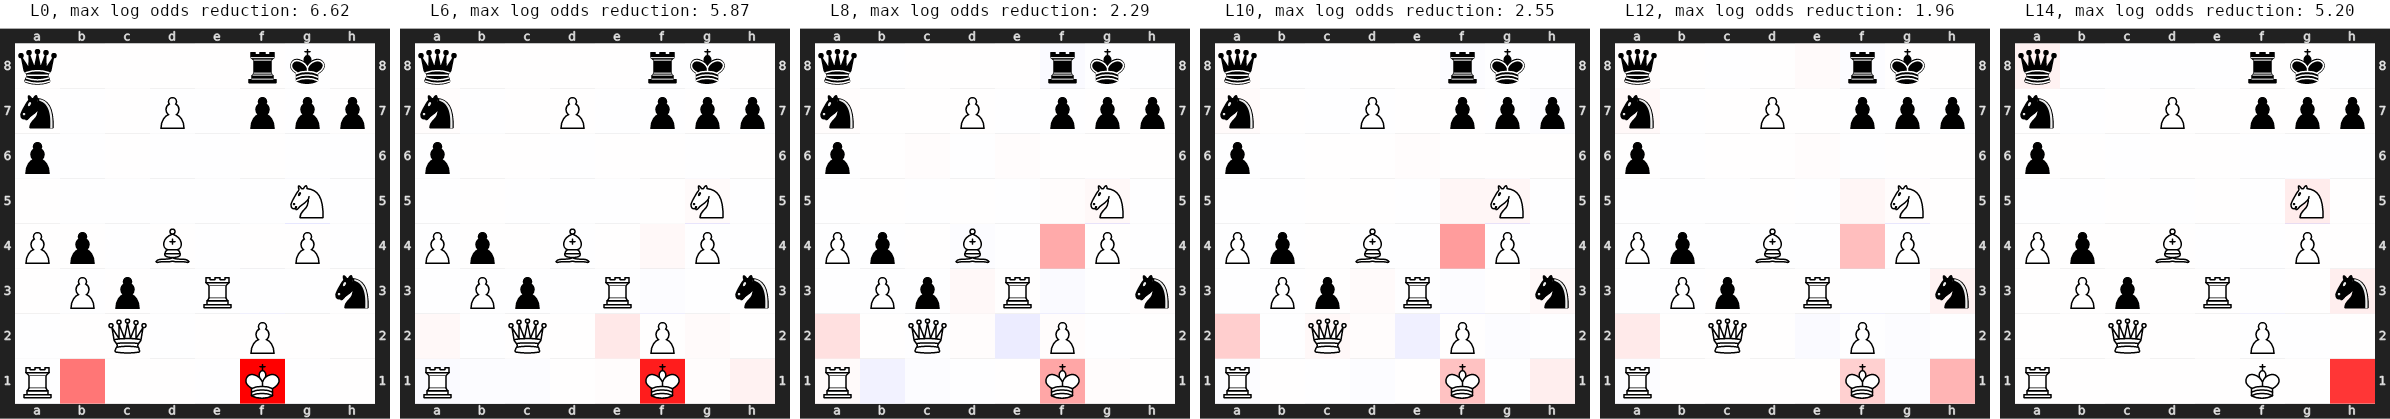

In [50]:
study.plot_examples(mask=mask, n=1)

## Ratings

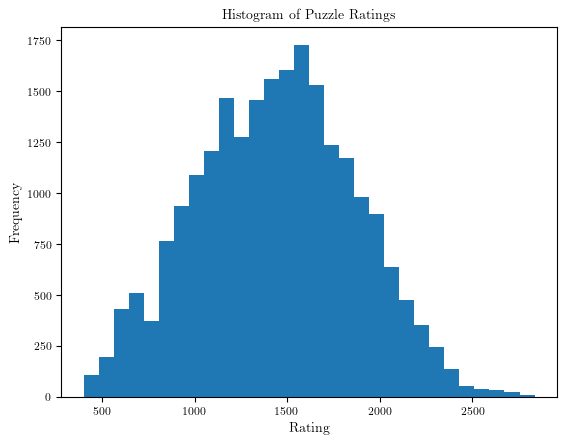

<Figure size 640x480 with 0 Axes>

In [16]:
# # Store puzzle ratings in a numpy array
# puzzle_ratings = puzzles["Rating"].to_numpy()
# puzzle_ratings_all = puzzles_all["Rating"].to_numpy()
# puzzle_ratings_no_forcing = puzzles_no_forcing["Rating"].to_numpy()

# # Plot histogram of puzzle ratings
# plt.hist(puzzle_ratings, bins=30, label="Interesting")
# plt.hist(puzzle_ratings_all, bins=30, label="All")
# plt.hist(puzzle_ratings_no_forcing, bins=30, label="No forcing")
# plt.show()

study.plot_rating_histogram(filename="rating_histogram.pdf")

### Exporting interesting puzzles

In [8]:
{k: len(v) for k, v in study.good_results.items()}

{'123': 15658,
 '112': 7065,
 '111': 4719,
 '122': 4634,
 '12345': 3436,
 '11234': 2167,
 '12333': 1350,
 '12344': 1296,
 '11231': 831,
 '12334': 751,
 '11233': 697,
 '11123': 619,
 '11222': 572,
 '12223': 514,
 '1234567': 501,
 '12234': 428,
 '12222': 423,
 '12342': 393,
 '12233': 325,
 '11112': 292,
 '12332': 277,
 '11223': 265,
 '11122': 259,
 '1123456': 238,
 '11111': 195,
 '12311': 180,
 '1234566': 164,
 '12314': 153,
 '11221': 140,
 '1234555': 135,
 '1233456': 114}

# Effects

In [ ]:
for possibility, mask in zip(list(study.good_results), study.good_mask):
    study.plot_residual_effects(mask=mask, allowed_lengths=[5,6,7,8,9], rating_range=(0, 5000))

In [51]:
len(study.good_results.keys())

36

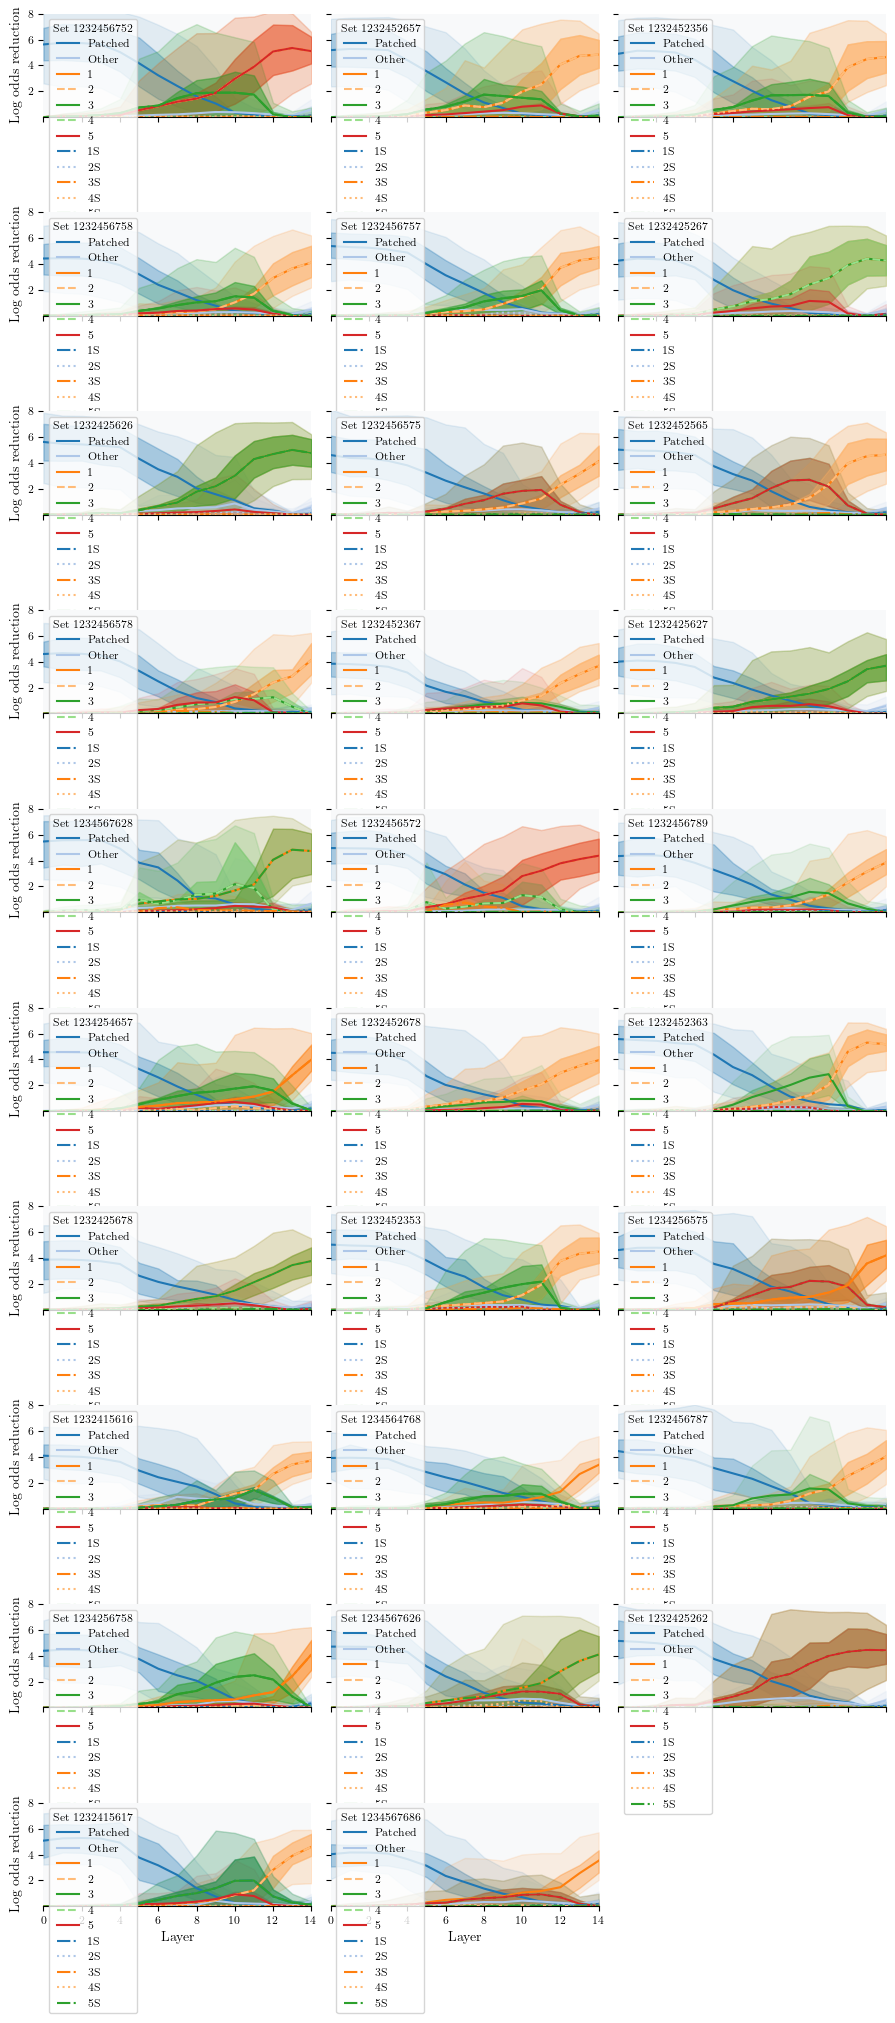

<Figure size 640x480 with 0 Axes>

In [54]:
study.plot_residual_effects_grid(n_cols=3, allowed_lengths=[5], filename="residual_effects_5_starting.pdf")

In [70]:
study.export_puzzles('1123344')

In [72]:
len(study.good_results['1123344'])

57

In [8]:
# for possibility, mask in zip(list(study.good_results), study.good_mask):
#     print(possibility)
#     try:
#         #print("Easy puzzles")
#         study.plot_residual_effects(mask=mask, allowed_lengths=[5,6,7,8,9], rating_range=(0, 5000))
#         #print("Medium puzzles")
#         study.plot_residual_effects(mask=mask, allowed_lengths=[5,6,7,8,9], rating_range=(1000, 2000))
#         #print("Hard puzzles")
#         study.plot_residual_effects(mask=mask, allowed_lengths=[5,6,7,8,9], rating_range=(2000, 3000))
#     except ValueError:
#         continue

# Ratings

In [1]:
study.plot_rating_grid(allowed_lengths=[3,4,5,6,7,8,9], n_cols=4)
study.plot_rating_layer_grid(allowed_lengths=[3,4,5,6,7,8,9], n_cols=4)

NameError: name 'study' is not defined

## Attention heads

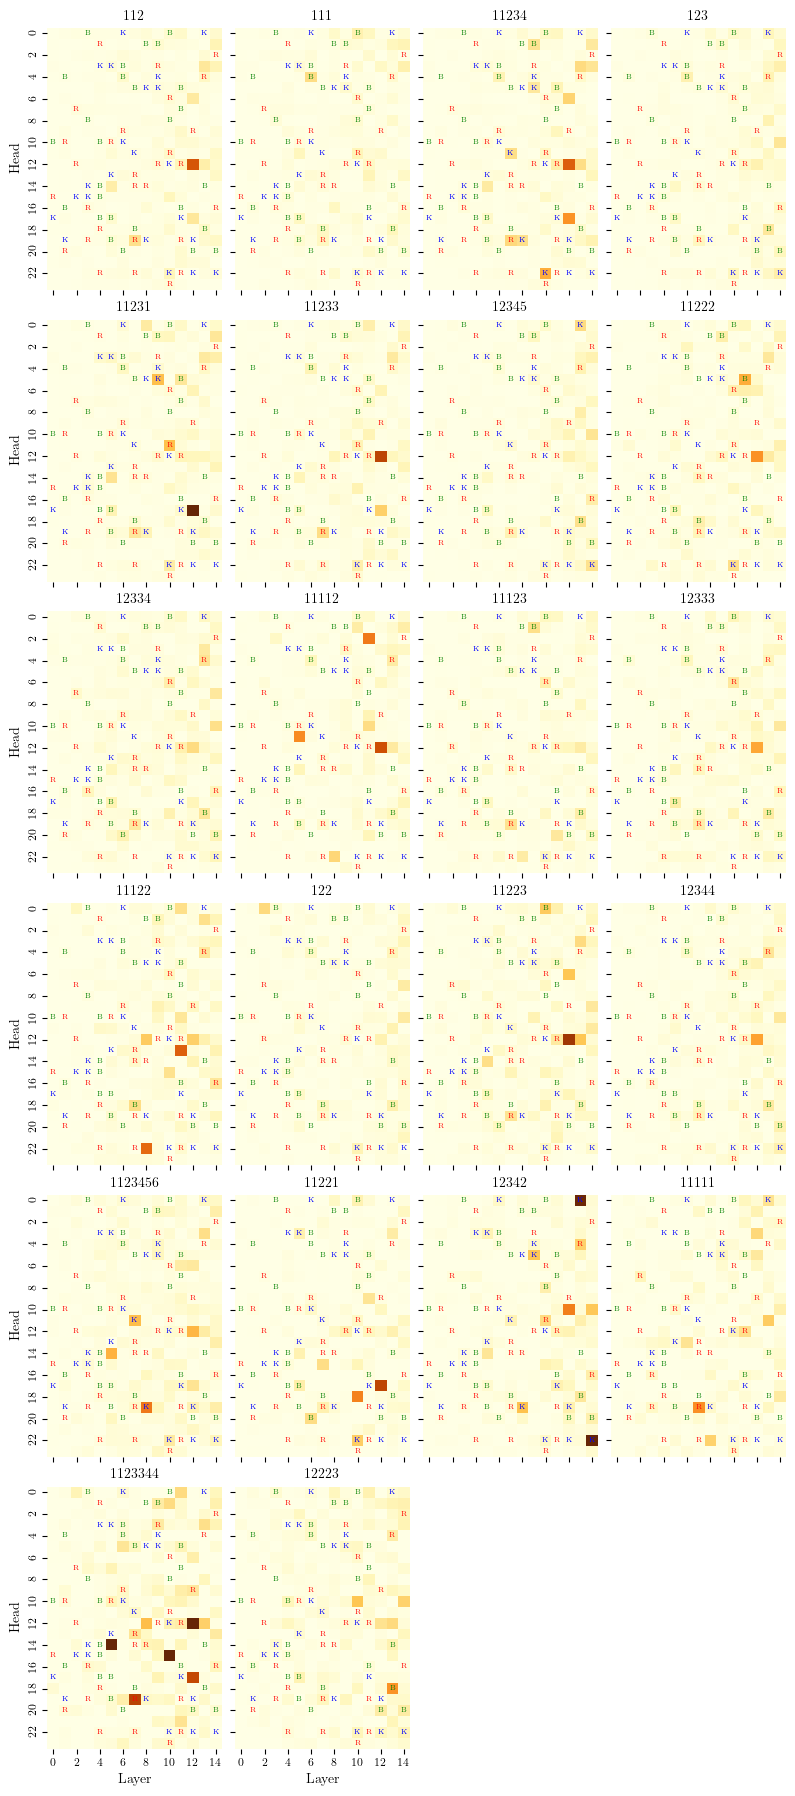

In [76]:
study.plot_attention_grid(allowed_lengths=[3,4,5,6,7,8,9], n_cols=4, vmax=0.73, rating_range=(1950, 5000))
study.create_head_to_possibilities_dict()
study.create_head_to_possibilities_dict_with_effects()

In [77]:
len(study.all_heads.keys())

10

In [78]:
# Convert the dict of 2D arrays to a 3D numpy array
keys = sorted(study.all_heads.keys())
first_array = study.all_heads[keys[0]]
num_rows, num_cols = first_array.shape
num_keys = len(keys)

all_heads_3d = np.zeros((num_keys, num_rows, num_cols))

for i, key in enumerate(keys):
    all_heads_3d[i] = study.all_heads[key]

print(f"Shape of the 3D array: {all_heads_3d.shape}")
print(f"Dimensions: {num_keys} keys x {num_rows} rows x {num_cols} columns")


Shape of the 3D array: (10, 15, 24)
Dimensions: 10 keys x 15 rows x 24 columns


In [79]:
all_heads_mean = np.mean(all_heads_3d, axis=0)

In [80]:
def dict_to_latex_table_2(data_dict, all_heads_mean):
    # Get the keys and sort them
    keys = sorted(data_dict.keys())
    
    # Get the shape of the first array to determine the number of columns
    first_array = data_dict[keys[0]]
    num_rows, num_cols = first_array.shape
    
    # Flatten the all_heads_mean array and get indices of top 10 values
    flat_indices = np.argsort(all_heads_mean.flatten())[-10:]
    
    # Convert flat indices to 2D indices
    columns_to_include = [(idx // num_cols, idx % num_cols) for idx in flat_indices[::-1]]
    
    # Start the LaTeX table
    latex_table = "\\begin{tabular}{l|" + "c" * len(columns_to_include) + "}\n"
    latex_table += "Key & " + " & ".join([f"L{i}H{j}" for i, j in columns_to_include]) + " \\\\\n"
    latex_table += "\\hline\n"
    
    # Add data rows
    for key in keys:
        array = np.nan_to_num(data_dict[key])
        row_data = []
        for i, j in columns_to_include:
            value = array[i, j]
            if abs(value) > 0.3:
                row_data.append(f"\\textbf{{{value:.2f}}}")
            elif abs(value) < 0.1:
                row_data.append(f"\\textcolor{{gray}}{{{value:.2f}}}")
            else:
                row_data.append(f"{value:.2f}")
        latex_table += f"{key} & " + " & ".join(row_data) + " \\\\\n"
    
    # End the LaTeX table
    latex_table += "\\end{tabular}"
    
    return latex_table

# Example usage
latex_output_2 = dict_to_latex_table_2(study.all_heads, all_heads_mean)
print(latex_output_2)


\begin{tabular}{l|cccccccccc}
Key & L12H12 & L12H17 & L7H19 & L13H3 & L5H14 & L12H6 & L10H22 & L13H12 & L14H1 & L13H18 \\
\hline
111 & \textcolor{gray}{0.02} & \textcolor{gray}{0.00} & \textcolor{gray}{0.08} & \textcolor{gray}{0.03} & \textcolor{gray}{0.04} & \textcolor{gray}{0.01} & \textcolor{gray}{0.05} & \textcolor{gray}{0.02} & 0.10 & \textcolor{gray}{0.09} \\
112 & \textbf{0.52} & 0.16 & 0.19 & 0.16 & 0.13 & 0.15 & \textcolor{gray}{0.10} & 0.13 & 0.11 & \textcolor{gray}{0.07} \\
11223 & \textbf{0.63} & \textcolor{gray}{0.10} & 0.18 & 0.21 & 0.20 & 0.27 & \textcolor{gray}{0.08} & 0.27 & \textcolor{gray}{0.09} & 0.10 \\
11231 & \textcolor{gray}{0.09} & \textbf{0.96} & 0.16 & 0.15 & 0.18 & 0.10 & 0.14 & \textcolor{gray}{0.09} & 0.17 & \textcolor{gray}{0.04} \\
11233 & \textbf{0.57} & 0.24 & 0.20 & 0.15 & 0.10 & 0.11 & 0.13 & \textcolor{gray}{0.09} & 0.11 & \textcolor{gray}{0.02} \\
11234 & \textbf{0.50} & \textbf{0.38} & 0.21 & 0.21 & 0.15 & 0.23 & \textbf{0.32} & 0.20 & 0.16 & \tex

In [58]:
# import numpy as np
# def dict_to_latex_table(data_dict):
#     # Get the keys and sort them
#     keys = sorted(data_dict.keys())
    
#     # Get the shape of the first array to determine the number of columns
#     first_array = data_dict[keys[0]]
#     num_rows, num_cols = first_array.shape
    
#     # Determine which columns to include and their maximum values
#     columns_to_include = []
#     for j in range(num_cols):
#         for i in range(num_rows):
#             if any(abs(np.nan_to_num(data_dict[key][i, j])) > 0.3 for key in keys):
#                 max_value = max(abs(np.nan_to_num(data_dict[key][i, j])) for key in keys)
#                 columns_to_include.append((i, j, max_value))
    
#     # Sort columns by their maximum value in descending order and keep only first 9
#     columns_to_include = sorted(columns_to_include, key=lambda x: x[2], reverse=True)[:9]
    
#     # Start the LaTeX table
#     latex_table = "\\begin{tabular}{l|" + "c" * len(columns_to_include) + "}\n"
#     latex_table += "Key & " + " & ".join([f"L{i}H{j}" for i, j, _ in columns_to_include]) + " \\\\\n"
#     latex_table += "\\hline\n"
    
#     # Add data rows
#     for key in keys:
#         array = np.nan_to_num(data_dict[key])
#         row_data = []
#         for i, j, _ in columns_to_include:
#             value = array[i, j]
#             if abs(value) > 0.3:
#                 row_data.append(f"\\textbf{{{value:.2f}}}")
#             elif abs(value) < 0.1:
#                 row_data.append(f"\\textcolor{{gray}}{{{value:.2f}}}")
#             else:
#                 row_data.append(f"{value:.2f}")
#         latex_table += f"{key} & " + " & ".join(row_data) + " \\\\\n"
    
#     # End the LaTeX table
#     latex_table += "\\end{tabular}"
    
#     return latex_table

# # Example usage
# latex_output = dict_to_latex_table(study.all_heads)
# print(latex_output)

In [66]:
# Print the results
for head, possibilities in study.head_to_possibilities.items():
    print(f"Head {head}: {len(possibilities)} possibilities")
    print(f"  {', '.join(possibilities)}")
    print()

Head (12, 12): 2 possibilities
  112, 123

Head (13, 4): 2 possibilities
  111, 122

Head (14, 1): 2 possibilities
  111, 122

Head (13, 18): 2 possibilities
  123, 122

Head (14, 10): 2 possibilities
  122, 123

Head (13, 3): 1 possibilities
  112

Head (7, 19): 1 possibilities
  112

Head (12, 17): 1 possibilities
  112

Head (12, 6): 1 possibilities
  112

Head (11, 13): 1 possibilities
  111

Head (11, 10): 1 possibilities
  111

Head (8, 12): 1 possibilities
  111

Head (14, 22): 1 possibilities
  123

Head (10, 22): 1 possibilities
  123

Head (6, 4): 1 possibilities
  122



In [69]:
# Print the results
for head, possibilities in study.head_to_possibilities_with_effects.items():
    print(f"Head {head}:")
    for possibility, effect in possibilities:
        print(f"  {possibility}: {effect:.4f}")
    print()

Head (13, 4):
  111: 0.2779
  122: 0.1666

Head (13, 18):
  123: 0.1815
  122: 0.1607

Head (14, 10):
  122: 0.1796
  123: 0.1746

Head (12, 12):
  112: 0.7319

Head (13, 3):
  112: 0.1939

Head (7, 19):
  112: 0.1896

Head (11, 13):
  111: 0.3864

Head (11, 10):
  111: 0.3510

Head (14, 22):
  123: 0.1762



In [ ]:
# (13, 3): Applies to 112 setups
# (13, 18): Applies to 123, 122 setups
# (12, 17): Applies to 11231 setups

# L12H17

In [15]:
study.export_puzzles('12344')

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:852: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

TypeError: AblationStudy.plot_ablation_effects() got an unexpected keyword argument 'ax'

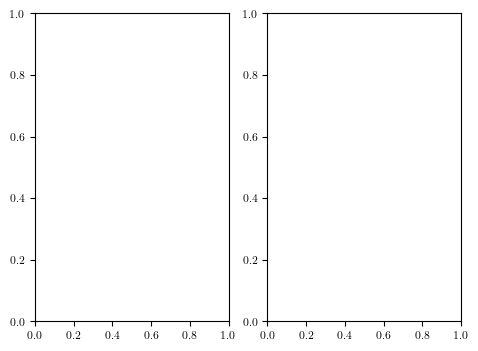

In [18]:
ablation_configs = [
    (['L5H14', 'L12H12', 'L12H17', 'L13H3', 'L13H12', 'L14H9', 'L14H11'], "11223"),
    (['L12H12', 'L12H17', 'L13H3', 'L13H18', 'L13H12', 'L7H19'], "1123344"),
    (['L12H12'], "112"),
    (['L12H12'], "123"),
    (['L12H17'], "11231"),
    (['L12H12', 'L13H3'], "11233"),
    (['L12H12', 'L13H3', 'L12H17'], "11234"),
    (['L12H12'], "1123456"),
    (['L12H12', 'L10H22'], "12223"),
    (['L12H12', 'L12H17'], "12334"),
    (['L12H12', 'L13H18'], "12344")
]

AblationStudy.plot_ablation_effects_grid(ablation_configs[:1], n_cols=2, filename="ablation_effects_grid_11223.pdf")

11223 L5H14


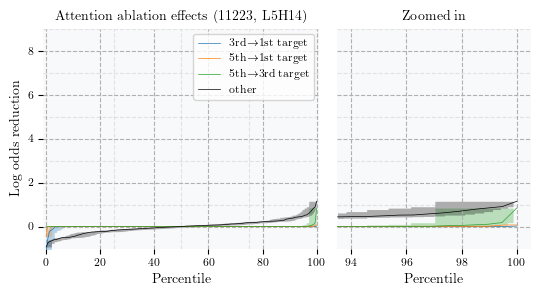

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

11223 L12H12


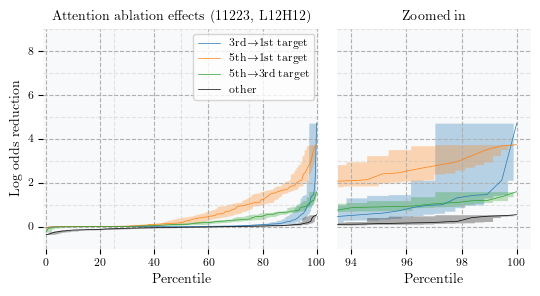

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

11223 L12H17


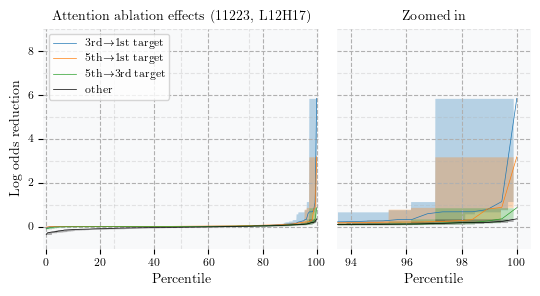

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

11223 L13H3


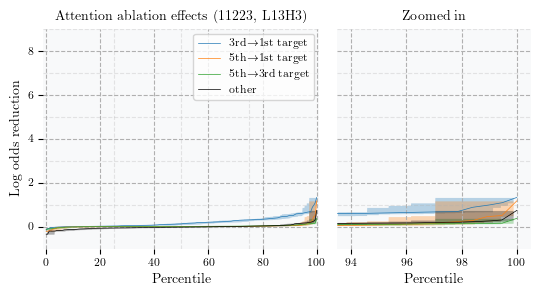

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

11223 L13H12


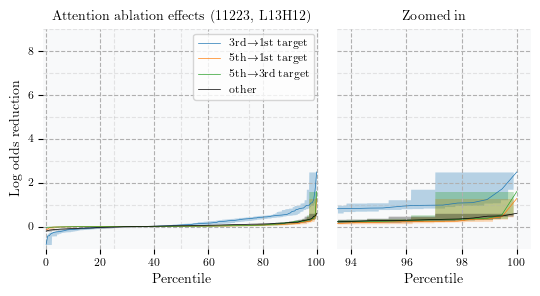

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

11223 L14H9


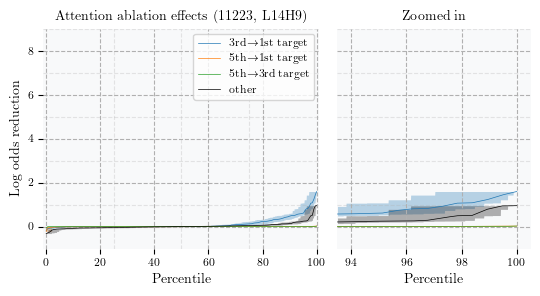

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

11223 L14H11


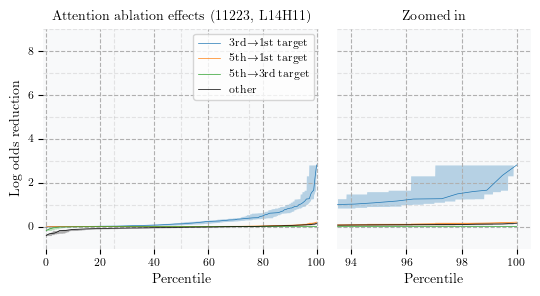

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

1123344 L12H12


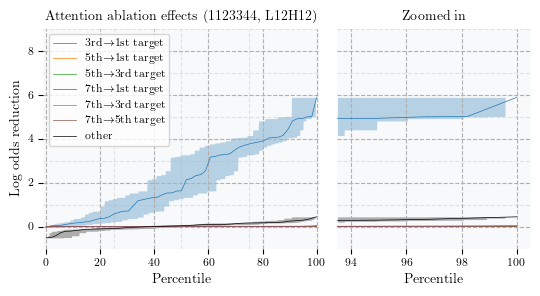

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

1123344 L12H17


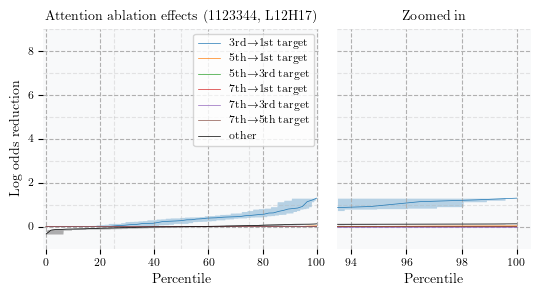

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

1123344 L13H3


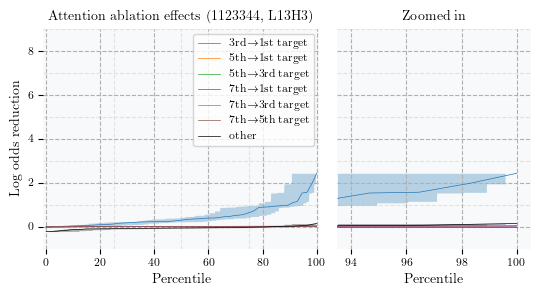

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

1123344 L13H18


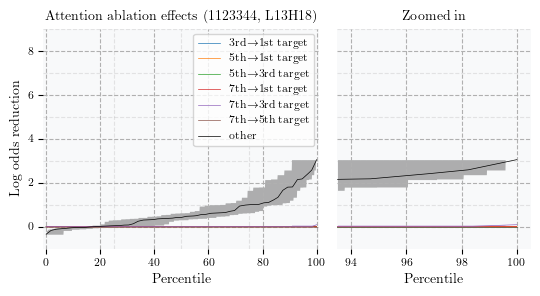

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

1123344 L13H12


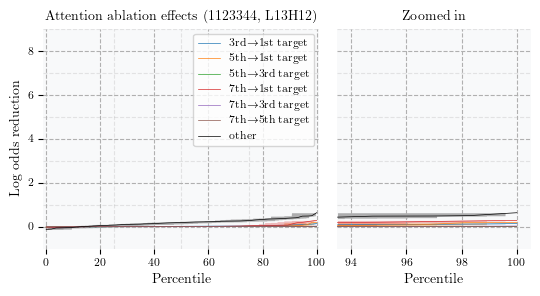

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

1123344 L7H19


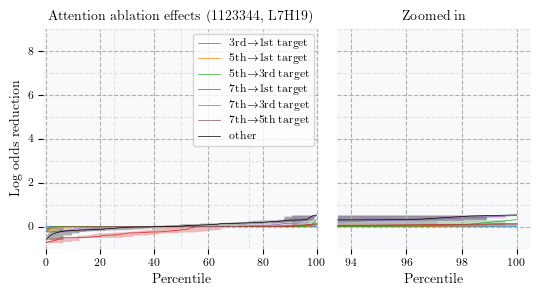

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

112 L12H12


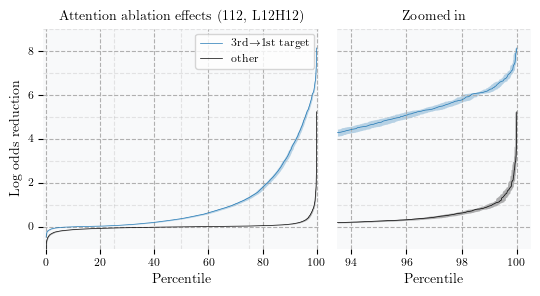

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

123 L12H12


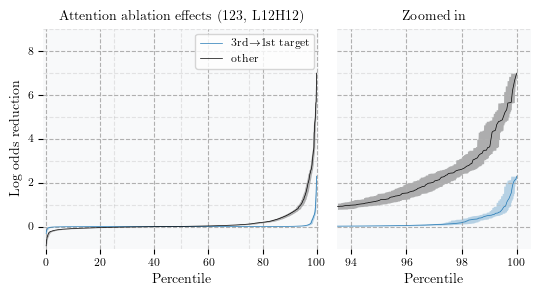

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

11231 L12H17


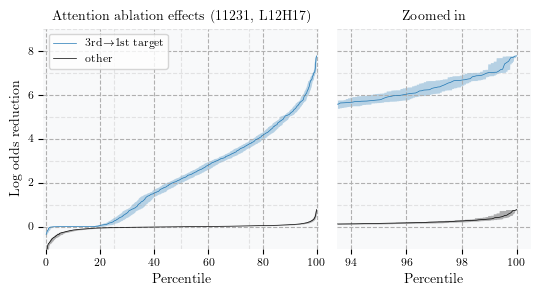

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

11233 L12H12


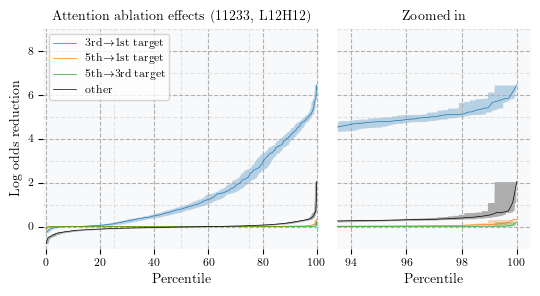

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

11233 L13H3


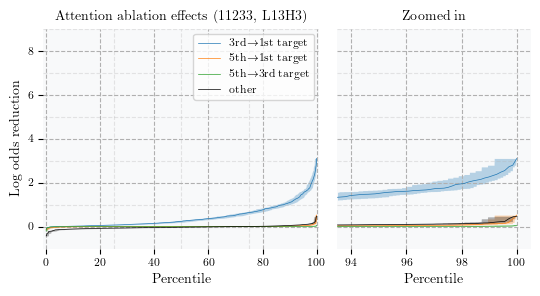

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

11234 L12H12


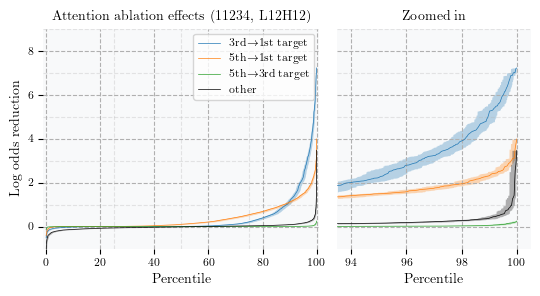

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

11234 L13H3


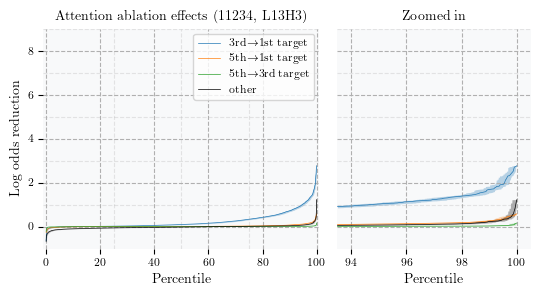

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

11234 L12H17


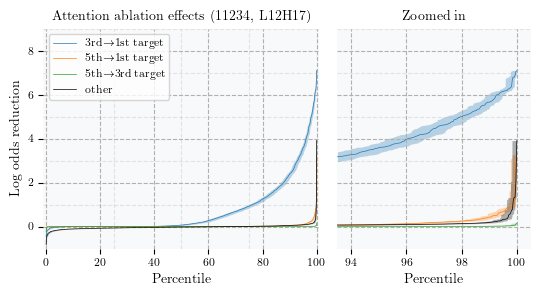

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

1123456 L12H12


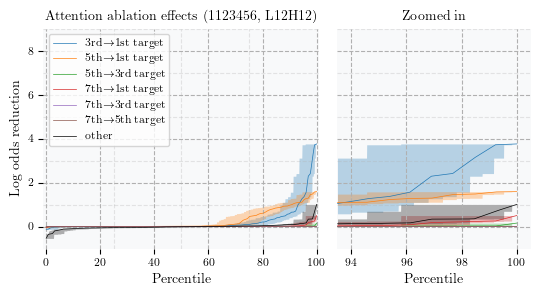

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

12223 L12H12


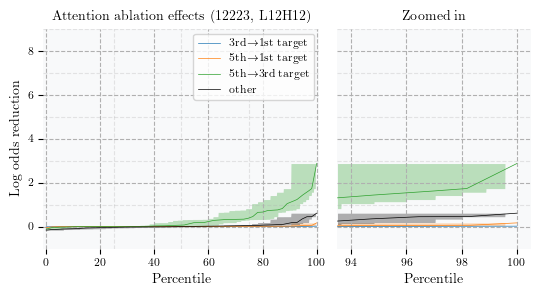

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

12223 L10H22


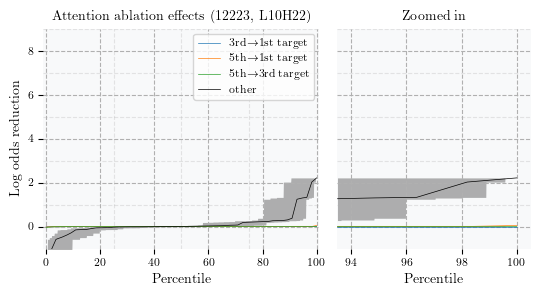

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

12334 L12H12


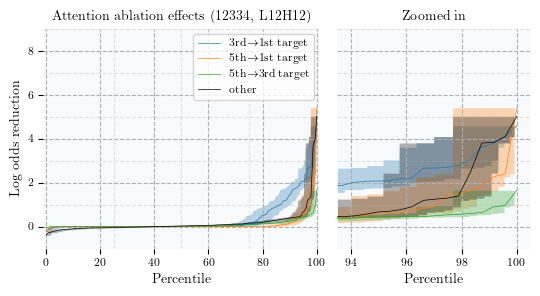

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

12334 L12H17


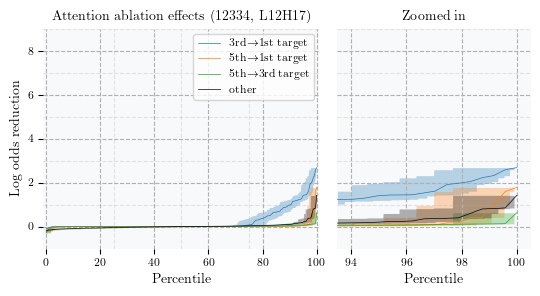

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

12344 L12H12


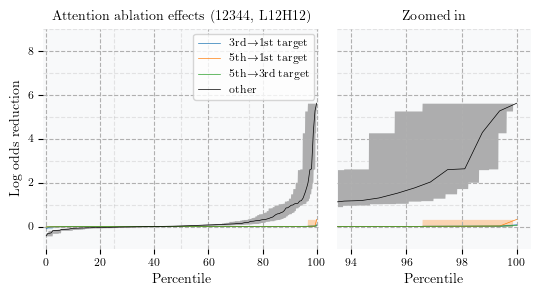

/home/dcruz/Pivotal/leela-interp/src/leela_interp/core/effect_study.py:857: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ablation[file_prefix] = torch.load("results/" + sel

12344 L13H18


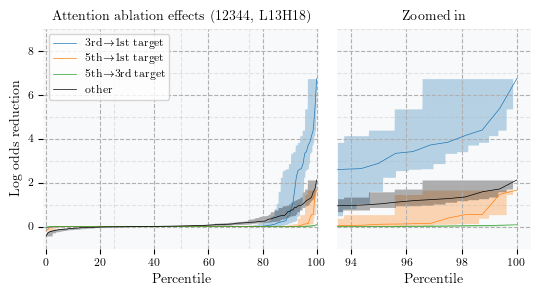

In [57]:
ablation_configs = [
    (['L5H14', 'L12H12', 'L12H17', 'L13H3', 'L13H12', 'L14H9', 'L14H11'], "11223"),
    (['L12H12', 'L12H17', 'L13H3', 'L13H18', 'L13H12', 'L7H19'], "1123344"),
    (['L12H12'], "112"),
    (['L12H12'], "123"),
    (['L12H17'], "11231"),
    (['L12H12', 'L13H3'], "11233"),
    (['L12H12', 'L13H3', 'L12H17'], "11234"),
    (['L12H12'], "1123456"),
    (['L12H12', 'L10H22'], "12223"),
    (['L12H12', 'L12H17'], "12334"),
    (['L12H12', 'L13H18'], "12344")
]

for cases, puzzle_set in ablation_configs:
    for case in cases:
        ablation_study = AblationStudy(folder_name=case + "_" + puzzle_set)
        print(puzzle_set, case)
        ablation_study.plot_ablation_effects(filename=f"ablation_effects_{case}_{puzzle_set}.pdf", puzzle_set=puzzle_set, LH=case)

In [39]:
list(study.good_results)

['112',
 '111',
 '11234',
 '123',
 '11231',
 '11233',
 '12345',
 '11222',
 '12334',
 '11112',
 '11123',
 '12333',
 '11122',
 '122',
 '11223',
 '12344',
 '1123456',
 '11221',
 '12342',
 '11111',
 '1123344',
 '12223']

0 ['c2a4', 'b4c3', 'a4a2', 'f6f7', 'a2f7'] [0.5920239090919495, 0.451749324798584, 0.8767738342285156, 0.6049863696098328, 0.8772741556167603]
0 ['c2a4', 'b4c3', 'a4a2', 'f6f7', 'a2f7'] [0.039466120302677155, 0.7535219788551331, 0.13934744894504547, 0.057812124490737915, 0.21995295584201813]
1 ['d6g3', 'h2h1', 'g3h4', 'f5h3', 'h4h3'] [0.9384021759033203, 1.0, 0.9300743937492371, 1.0, 0.8777098059654236]
1 ['d6g3', 'h2h1', 'g3h4', 'f5h3', 'h4h3'] [0.02824551984667778, 1.0, 0.6084303259849548, 1.0, 0.9214638471603394]
2 ['g2g4', 'h5h4', 'd6h6', 'f4h5', 'h6h5'] [0.934381902217865, 1.0, 0.9638696908950806, 1.0, 0.9636649489402771]
2 ['g2g4', 'h5h4', 'd6h6', 'f4h5', 'h6h5'] [0.034018658101558685, 1.0, 0.4383273124694824, 1.0, 0.7290634512901306]
3 ['g2g5', 'h4f4', 'g5f5', 'f4f3', 'f5f3'] [0.7100353240966797, 0.3128618001937866, 0.9383967518806458, 0.504242479801178, 0.9710922837257385]
3 ['g2g5', 'h4f4', 'g5f5', 'f4f3', 'f5f3'] [0.03426261618733406, 0.8016296029090881, 0.4578755497932434, 0

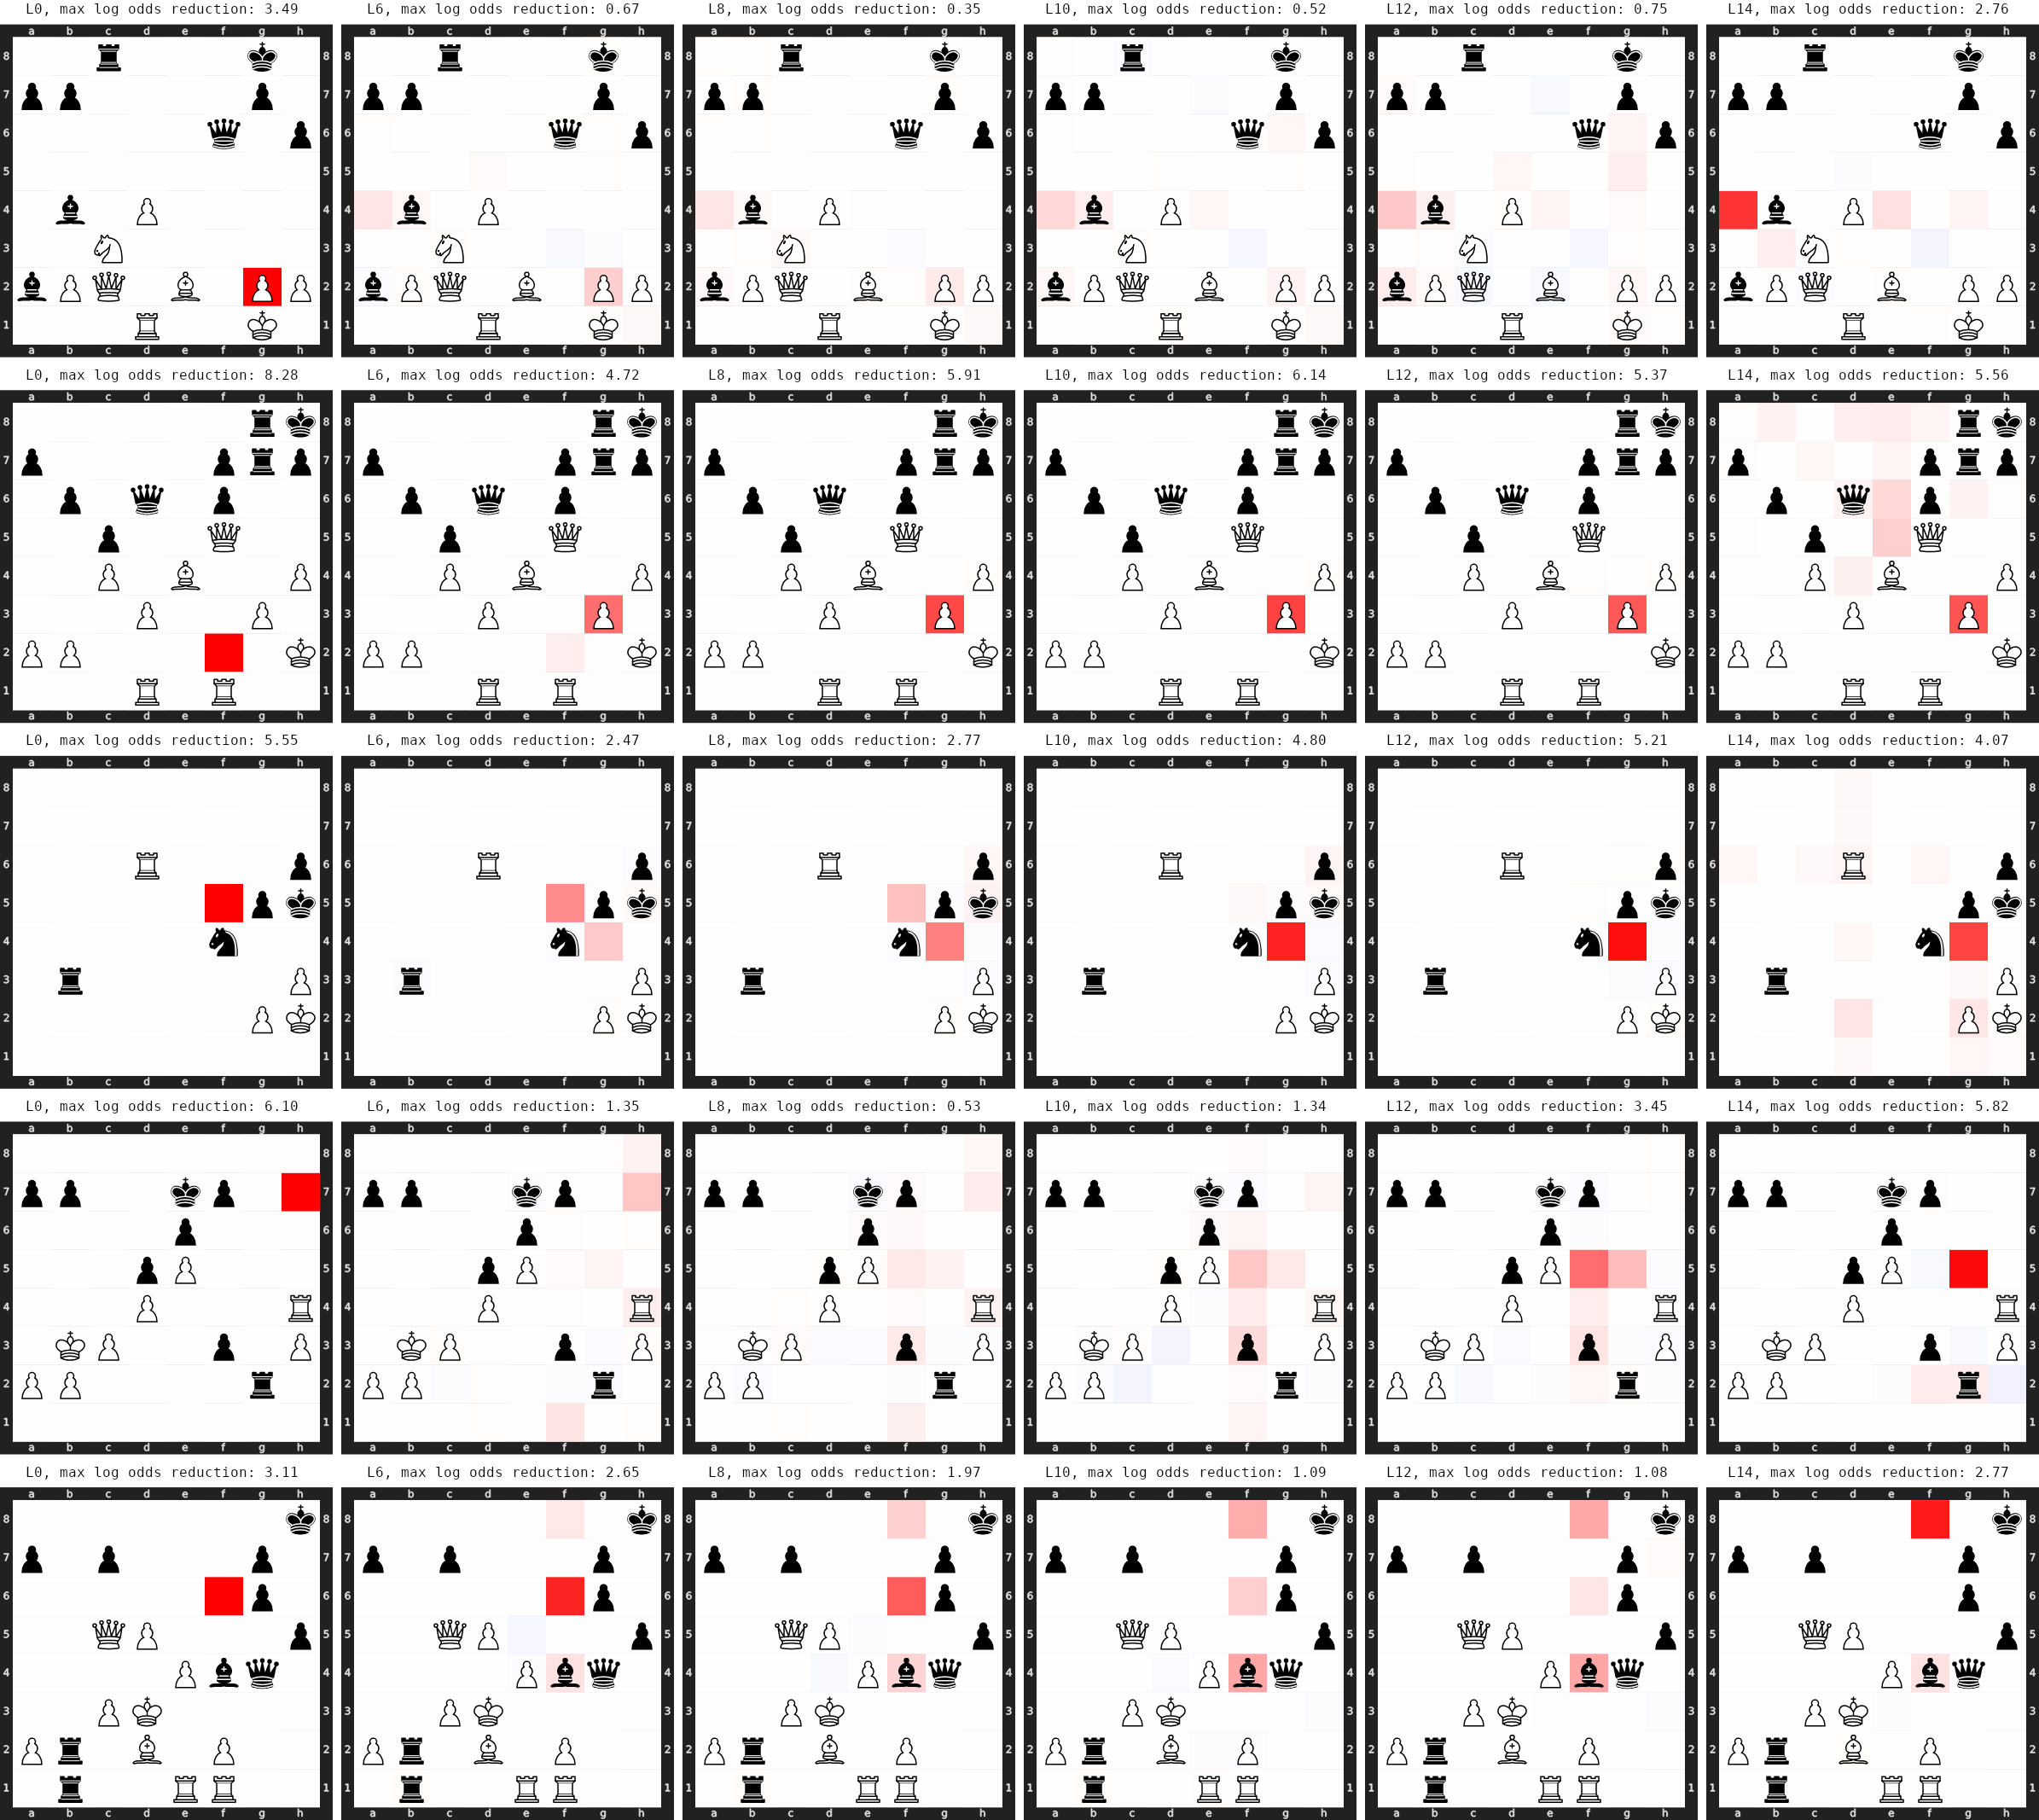

In [40]:
study.plot_examples(mask=study.good_mask[-7])

# Probing

In [ ]:
SETTING_TO_PRETTY_NAME = {
    "main": "Probe on trained model",
    "random_model": "Probe on random model",
}


def plot_probe_results(split="all"):
    fh.set(fast=False)
    plt.figure(figsize=(fh.HALF_WIDTH, 2))

    for i, setting in enumerate(["main", "random_model"]):
        results = np.zeros((15, 5))
        for seed in range(5):
            with open(f"results/probing/{split}/{seed}/{setting}.pkl", "rb") as f:
                new_results = pickle.load(f)
                results[:, seed] = new_results["accuracies"]

        means = results.mean(1)
        squared_seed_errors = results.var(1) / results.shape[1]
        # Size of the eval dataset is 30% of all puzzles
        squared_acc_errors = means * (1 - means) / (0.3 * len(puzzles))
        # 2 sigma errors
        errors = 2 * np.sqrt(squared_seed_errors + squared_acc_errors)

        max_layer = means.argmax()

        print(
            f"Max accuracy ({setting}, L{max_layer}): {means[max_layer]:.2f} +- {errors[max_layer]:.2f}"
        )
        plt.plot(
            means,
            label=SETTING_TO_PRETTY_NAME[setting],
            color=fh.COLORS[i],
            linewidth=fh.LINE_WIDTH,
        )
        plt.fill_between(
            range(15),
            means - errors,
            means + errors,
            color=fh.COLORS[i],
            alpha=fh.ERROR_ALPHA,
            linewidth=0,
        )

    plt.title("Third move prediction")
    plt.xlabel("Layer")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.ylim(0, 1.0)
    plt.xlim(0, 14)
    plt.gca().spines[:].set_visible(False)
    plt.gca().set_facecolor(fh.PLOT_FACE_COLOR)
    plt.grid(linestyle="--")
    plt.grid(which="minor", alpha=0.3, linestyle="--")

In [ ]:
plot_probe_results()
fh.save("figures/probing.pdf")

In [ ]:
plot_probe_results(split="different_targets")
fh.save(different_targets_dir / "probing.pdf")
plot_probe_results(split="same_targets")
fh.save(same_targets_dir / "probing.pdf")

# Piece movement heads

In [107]:
with open("interesting_puzzles.pkl", "rb") as f:
    puzzles = pickle.load(f)
len(puzzles)

22517

In [109]:
knight_heads

[(0, 17),
 (1, 19),
 (3, 14),
 (3, 15),
 (4, 3),
 (5, 3),
 (5, 13),
 (8, 5),
 (9, 5),
 (14, 22),
 (2, 15),
 (6, 0),
 (6, 10),
 (7, 11),
 (8, 19),
 (9, 4),
 (10, 12),
 (10, 22),
 (11, 17),
 (12, 19),
 (12, 22),
 (13, 0)]

In [76]:
len(knight_heads), len(bishop_heads), len(rook_heads)

(22, 27, 29)

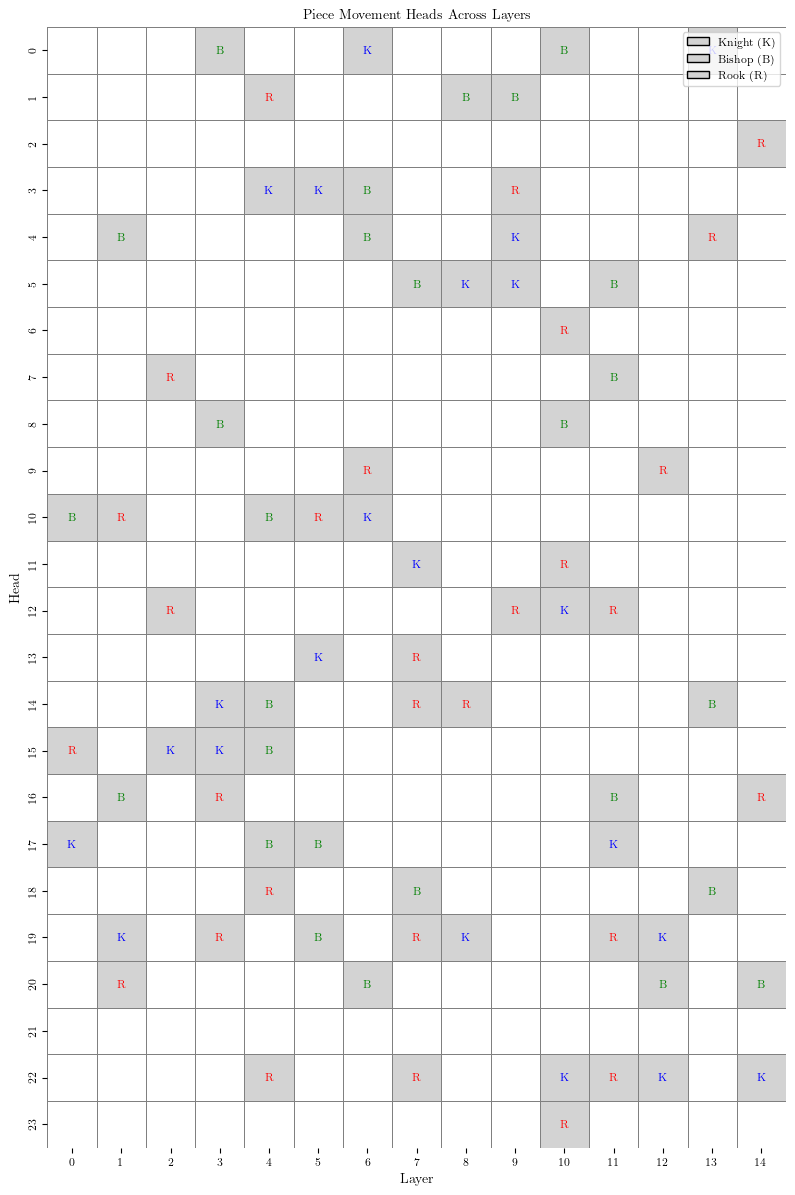

In [77]:
# Create a matrix to hold the data
n_layers = 15
n_heads = 24
data = np.full((n_heads, n_layers), '', dtype=object)

# Fill the matrix with values for each piece type
for layer, head in knight_heads:
    data[head, layer] = 'K'
for layer, head in bishop_heads:
    data[head, layer] = 'B'
for layer, head in rook_heads:
    data[head, layer] = 'R'

# Set up the plot
plt.figure(figsize=(8, 12))

# Create the heatmap
ax = sns.heatmap(data.astype(bool).astype(int), cmap=['white', 'lightgray'], 
                 cbar=False, linewidths=0.5, linecolor='gray')

# Add text annotations
for i in range(n_heads):
    for j in range(n_layers):
        if data[i, j]:
            text_color = 'blue' if data[i, j] == 'K' else 'green' if data[i, j] == 'B' else 'red'
            ax.text(j+0.5, i+0.5, data[i, j], ha='center', va='center', color=text_color, fontweight='bold')

# Customize the plot
plt.title('Piece Movement Heads Across Layers')
plt.xlabel('Layer')
plt.ylabel('Head')

# Create a custom legend
legend_elements = [Patch(facecolor='lightgray', edgecolor='black', label='Knight (K)'),
                   Patch(facecolor='lightgray', edgecolor='black', label='Bishop (B)'),
                   Patch(facecolor='lightgray', edgecolor='black', label='Rook (R)')]
plt.legend(handles=legend_elements, loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

In [110]:
N = 4
patterns = torch.zeros(N, 15, 24, 64, 64, device=device)

boards = [LeelaBoard.from_puzzle(p) for _, p in puzzles.sample(N).iterrows()]

with model.trace(boards):
    for layer in range(15):
        patterns[:, layer] = model.attention_scores(layer).output.save()

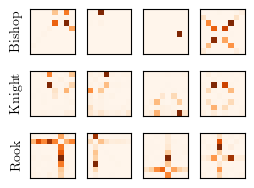

In [111]:
query_indices = random.sample(range(64), N)
plt.figure(figsize=(fh.HALF_WIDTH, 2))
layer = 5

layer_bishop_heads = [head for _layer, head in bishop_heads if _layer == layer]
layer_knight_heads = [head for _layer, head in knight_heads if _layer == layer]
layer_rook_heads = [head for _layer, head in rook_heads if _layer == layer]

if not (layer_bishop_heads and layer_knight_heads and layer_rook_heads):
    raise ValueError("No good heads in this layer, pick a different one")

bishop_head = random.choice(layer_bishop_heads)
knight_head = random.choice(layer_knight_heads)
rook_head = random.choice(layer_rook_heads)

fh.set()

for row, (name, head) in enumerate(
    zip(["Bishop", "Knight", "Rook"], [bishop_head, knight_head, rook_head])
):
    for i in range(N):
        plt.subplot(3, N, row * N + i + 1)
        if i == 0:
            plt.ylabel(
                name,
                rotation=90,
                labelpad=10,
                verticalalignment="center",
            )
        plt.imshow(
            patterns[i, layer, head, query_indices[i], :].cpu().numpy().reshape(8, 8),
            cmap="Oranges",
        )
        plt.xticks([])
        plt.yticks([])
fh.save("figures/piece_movement_patterns.pdf")

In [113]:
save_dir = Path("results/piece_movement_heads")
data = torch.load(save_dir / "effects.pt", map_location=device)
effects = data["effects"]
piece_movement_mask = data["mask"]

/tmp/ipykernel_2770328/120337627.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(save_dir / "effects.pt", map_location=device)


FileNotFoundError: [Errno 2] No such file or directory: 'results/piece_movement_heads/effects.pt'

In [ ]:
def plot_piece_movement_ablation(mask=None):
    if mask is None:
        mask = slice(None)
    else:
        mask = mask[piece_movement_mask]
    data = {}
    colors = {}
    for i, name in enumerate(["Main ablation", "Other piece types", "Random square"]):
        data[name] = effects[("key", name)].squeeze().cpu().numpy()[mask]
        colors[name] = fh.COLORS[i]
    fh.set()
    fh.plot_percentiles(
        data,
        title="Piece movement head ablation",
        colors=colors,
        figsize=(fh.HALF_WIDTH, 2),
        y_lower=-1,
        tick_frequency=25,
        y_ticks=[0, 2, 4, 6, 8],
    )

In [ ]:
plot_piece_movement_ablation()
fh.save("figures/piece_movement_ablation.pdf")

In [ ]:
plot_piece_movement_ablation(mask=different_targets_mask)
fh.save(different_targets_dir / "piece_movement_ablation.pdf")
plot_piece_movement_ablation(mask=same_targets_mask)
fh.save(same_targets_dir / "piece_movement_ablation.pdf")

# Positional encodings
These are the domain-specific positional encodings used by Leela.

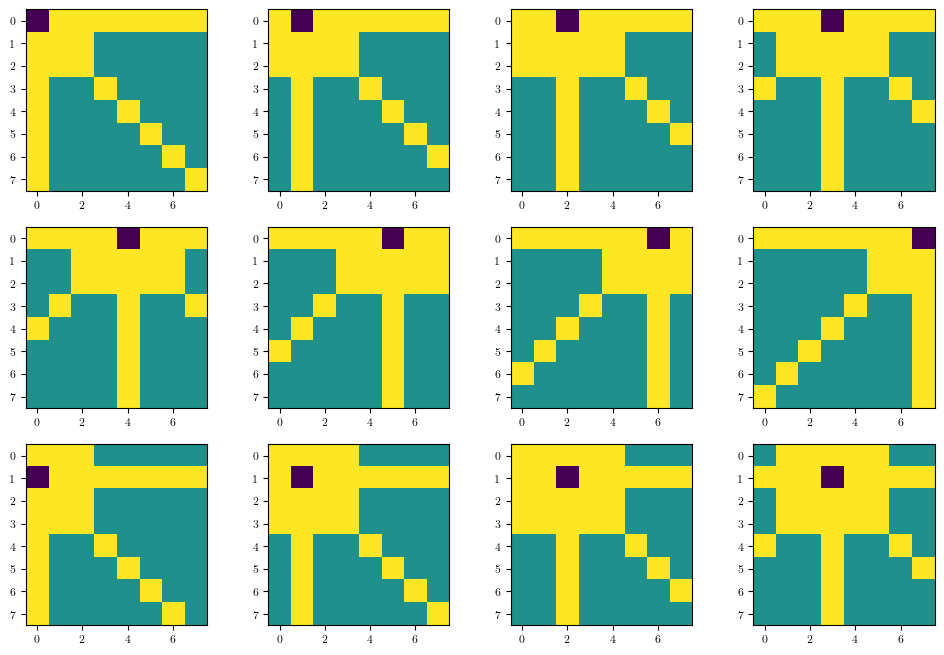

In [47]:
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(
        model._lc0_model.initializers.onnx_initializer_4.cpu()
        .numpy()[0, i]
        .reshape(8, 8)
    )

plt.show()